<a href="https://colab.research.google.com/github/Sukyeong02/DALC/blob/main/yolo_v1_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### model

In [ ]:
import torch
import torch.nn as nn

In [ ]:
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [ ]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

### utils

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

In [ ]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)


def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

### dataset
https://www.kaggle.com/datasets/aladdinpersson/pascalvoc-yolo?select=labels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
import os

zip_file_path = '/content/drive/MyDrive/DALC/PascalVOC_YOLO.zip'  # ZIP 파일의 경로
extracted_folder_path = '/content/drive/MyDrive/DALC/data/'  # 압축을 해제할 폴더 경로

# ZIP 파일 압축 해제
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# 압축 해제 후 파일 목록 출력
extracted_files = os.listdir(extracted_folder_path)
print("압축 해제된 파일 목록:", extracted_files)

압축 해제된 파일 목록: ['100examples.csv', '8examples.csv', 'generate_csv.py', 'get_data', 'images', 'labels', 'test.csv', 'train.csv']


In [ ]:
import torch
import os
import pandas as pd
from PIL import Image

In [ ]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(
        self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index): #csv파일에서 데이터 정보 가져오기
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes) #크기 재설정

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:

            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)

            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
            if label_matrix[i, j, 20] == 0:
                # Set that there exists an object
                label_matrix[i, j, 20] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 21:25] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

### loss

In [ ]:
class YoloLoss(nn.Module):

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5 #객체가 없는 경우의 손실 가중치
        self.lambda_coord = 5 #바운딩 박스 좌표 손실 가중치

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        #예측된 바운딩 박스와 실제 바운딩 박스 사이의 iou 값 계산
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two
        # predictions, which is the one with highest Iou calculated previously.
        #바운딩 박스 좌표 예측과 실제 바운딩 박스를 비교해 바운딩 박스 손실 계산
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        #좌표 값에 제곱근을 적용하고, 예측된 바운딩 박스의 폭과 높이 값을 부호화
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #
        #객체 관련 손실을 계산 -> 예측된 바운딩 박스의 신뢰도 값을 가져와서 객체 관련 손실을 계산
        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #
        #객체가 없을 때의 손실 -> 예측된 바운딩 박스의 신뢰도 값 중 큰 값을 선택하여 계산
        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #
        #클래스 예측 손실 ->  예측된 바운딩 박스의 클래스 예측과 실제 클래스 정보를 비교하여 손실을 계산
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

### train

In [ ]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
import time #추가

In [ ]:
seed = 123
torch.manual_seed(seed)

In [ ]:
# Hyperparameters etc.
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 100
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "/content/drive/MyDrive/DALC/data/images"
LABEL_DIR = "/content/drive/MyDrive/DALC/data/labels"

In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [ ]:
#추가
train_dataset = VOCDataset(
    "/content/drive/MyDrive/DALC/data/100examples.csv",
    transform=transform,
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR,
)

test_dataset = VOCDataset(
    "/content/drive/MyDrive/DALC/data/test.csv",
    transform=transform,
    img_dir = IMG_DIR,
    label_dir= LABEL_DIR,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
#추가
# Instantiate the model
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)

# Compile the model
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Define the loss function
loss_fn = YoloLoss()

In [ ]:
#추가
# Save train history
history_loss = []  # For epoch vs. loss
history_mAP = [] # For epoch vs. mAP

num_epochs = 100

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    model.train()  # Set the model to training mode

    start_time = time.time() # Start time of the epoch

    mean_loss = []

    # Iterate over the training data in batches
    for inputs, labels in train_loader:
        # Move the inputs and labels to the selected device
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        torch.cuda.empty_cache() # Limit GPU memory growth

        # Calculate the loss
        loss = loss_fn(outputs, labels)
        mean_loss.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.cuda.empty_cache() # Limit GPU memory growth

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of the epoch

    # Use the trained model to predict label
    pred_boxes, target_boxes = get_bboxes(
        train_loader, model, iou_threshold=0.5, threshold=0.4
    )

    # Calculate the mean average precision after every epoch/training
    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )

    history_loss.append(sum(mean_loss)/len(mean_loss))
    history_mAP.append(mean_avg_prec)

    # Print the epoch duration
    tqdm.write(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Print the loss and accuracy for training and validation data
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {sum(mean_loss)/len(mean_loss):.4f}, mAP: {mean_avg_prec:.4f}")

Epochs:   1%|          | 1/100 [00:06<09:58,  6.04s/it]

Epoch 1 completed in 3.90 seconds
Epoch [1/100], Loss: 865.4460, mAP: 0.0000


Epochs:   2%|▏         | 2/100 [00:11<09:15,  5.67s/it]

Epoch 2 completed in 3.49 seconds
Epoch [2/100], Loss: 569.6874, mAP: 0.0000


Epochs:   3%|▎         | 3/100 [00:17<09:24,  5.82s/it]

Epoch 3 completed in 3.57 seconds
Epoch [3/100], Loss: 444.9616, mAP: 0.0000


Epochs:   4%|▍         | 4/100 [00:22<09:06,  5.70s/it]

Epoch 4 completed in 3.62 seconds
Epoch [4/100], Loss: 375.6768, mAP: 0.0000


Epochs:   5%|▌         | 5/100 [00:28<08:53,  5.62s/it]

Epoch 5 completed in 3.49 seconds
Epoch [5/100], Loss: 311.6386, mAP: 0.0000


Epochs:   6%|▌         | 6/100 [00:34<08:51,  5.66s/it]

Epoch 6 completed in 3.79 seconds
Epoch [6/100], Loss: 274.7794, mAP: 0.0000


Epochs:   7%|▋         | 7/100 [00:39<08:39,  5.58s/it]

Epoch 7 completed in 3.54 seconds
Epoch [7/100], Loss: 239.3922, mAP: 0.0000


Epochs:   8%|▊         | 8/100 [00:45<08:46,  5.72s/it]

Epoch 8 completed in 3.70 seconds
Epoch [8/100], Loss: 202.0803, mAP: 0.0500


Epochs:   9%|▉         | 9/100 [00:51<08:34,  5.65s/it]

Epoch 9 completed in 3.44 seconds
Epoch [9/100], Loss: 188.1784, mAP: 0.0128


Epochs:  10%|█         | 10/100 [00:56<08:34,  5.72s/it]

Epoch 10 completed in 3.43 seconds
Epoch [10/100], Loss: 168.6348, mAP: 0.1384


Epochs:  11%|█         | 11/100 [01:02<08:29,  5.72s/it]

Epoch 11 completed in 3.63 seconds
Epoch [11/100], Loss: 146.4832, mAP: 0.1891


Epochs:  12%|█▏        | 12/100 [01:08<08:18,  5.66s/it]

Epoch 12 completed in 3.45 seconds
Epoch [12/100], Loss: 145.4848, mAP: 0.2483


Epochs:  13%|█▎        | 13/100 [01:14<08:22,  5.78s/it]

Epoch 13 completed in 3.88 seconds
Epoch [13/100], Loss: 123.8650, mAP: 0.2863


Epochs:  14%|█▍        | 14/100 [01:19<08:14,  5.75s/it]

Epoch 14 completed in 3.43 seconds
Epoch [14/100], Loss: 121.9276, mAP: 0.3694


Epochs:  15%|█▌        | 15/100 [01:26<08:21,  5.90s/it]

Epoch 15 completed in 3.56 seconds
Epoch [15/100], Loss: 109.3892, mAP: 0.4618


Epochs:  16%|█▌        | 16/100 [01:31<08:03,  5.76s/it]

Epoch 16 completed in 3.34 seconds
Epoch [16/100], Loss: 99.3262, mAP: 0.4998


Epochs:  17%|█▋        | 17/100 [01:37<08:02,  5.82s/it]

Epoch 17 completed in 3.38 seconds
Epoch [17/100], Loss: 98.9752, mAP: 0.5288


Epochs:  18%|█▊        | 18/100 [01:43<08:10,  5.99s/it]

Epoch 18 completed in 3.89 seconds
Epoch [18/100], Loss: 88.8074, mAP: 0.6469


Epochs:  19%|█▉        | 19/100 [01:49<07:53,  5.84s/it]

Epoch 19 completed in 3.35 seconds
Epoch [19/100], Loss: 84.8767, mAP: 0.6426


Epochs:  20%|██        | 20/100 [01:55<07:47,  5.85s/it]

Epoch 20 completed in 3.75 seconds
Epoch [20/100], Loss: 78.4291, mAP: 0.7207


Epochs:  21%|██        | 21/100 [02:00<07:32,  5.73s/it]

Epoch 21 completed in 3.33 seconds
Epoch [21/100], Loss: 78.9105, mAP: 0.7022


Epochs:  22%|██▏       | 22/100 [02:06<07:36,  5.85s/it]

Epoch 22 completed in 3.41 seconds
Epoch [22/100], Loss: 76.7570, mAP: 0.6951


Epochs:  23%|██▎       | 23/100 [02:12<07:25,  5.78s/it]

Epoch 23 completed in 3.39 seconds
Epoch [23/100], Loss: 71.2329, mAP: 0.7499


Epochs:  24%|██▍       | 24/100 [02:18<07:24,  5.85s/it]

Epoch 24 completed in 3.39 seconds
Epoch [24/100], Loss: 63.0820, mAP: 0.7521


Epochs:  25%|██▌       | 25/100 [02:24<07:16,  5.81s/it]

Epoch 25 completed in 3.58 seconds
Epoch [25/100], Loss: 64.5139, mAP: 0.8016


Epochs:  26%|██▌       | 26/100 [02:29<07:06,  5.77s/it]

Epoch 26 completed in 3.35 seconds
Epoch [26/100], Loss: 71.9460, mAP: 0.8485


Epochs:  27%|██▋       | 27/100 [02:35<07:03,  5.80s/it]

Epoch 27 completed in 3.70 seconds
Epoch [27/100], Loss: 60.5988, mAP: 0.8005


Epochs:  28%|██▊       | 28/100 [02:41<06:52,  5.73s/it]

Epoch 28 completed in 3.40 seconds
Epoch [28/100], Loss: 57.3450, mAP: 0.8346


Epochs:  29%|██▉       | 29/100 [02:47<06:56,  5.87s/it]

Epoch 29 completed in 3.49 seconds
Epoch [29/100], Loss: 55.2455, mAP: 0.7798


Epochs:  30%|███       | 30/100 [02:53<06:43,  5.77s/it]

Epoch 30 completed in 3.39 seconds
Epoch [30/100], Loss: 51.7579, mAP: 0.8420


Epochs:  31%|███       | 31/100 [02:59<06:43,  5.84s/it]

Epoch 31 completed in 3.37 seconds
Epoch [31/100], Loss: 49.2318, mAP: 0.8734


Epochs:  32%|███▏      | 32/100 [03:04<06:35,  5.82s/it]

Epoch 32 completed in 3.58 seconds
Epoch [32/100], Loss: 50.0469, mAP: 0.8290


Epochs:  33%|███▎      | 33/100 [03:10<06:25,  5.75s/it]

Epoch 33 completed in 3.43 seconds
Epoch [33/100], Loss: 47.5952, mAP: 0.8098


Epochs:  34%|███▍      | 34/100 [03:16<06:23,  5.81s/it]

Epoch 34 completed in 3.77 seconds
Epoch [34/100], Loss: 43.4670, mAP: 0.8468


Epochs:  35%|███▌      | 35/100 [03:21<06:12,  5.73s/it]

Epoch 35 completed in 3.42 seconds
Epoch [35/100], Loss: 46.0452, mAP: 0.9114


Epochs:  36%|███▌      | 36/100 [03:28<06:17,  5.90s/it]

Epoch 36 completed in 3.47 seconds
Epoch [36/100], Loss: 42.9719, mAP: 0.8950


Epochs:  37%|███▋      | 37/100 [03:33<06:05,  5.80s/it]

Epoch 37 completed in 3.42 seconds
Epoch [37/100], Loss: 44.2215, mAP: 0.9187


Epochs:  38%|███▊      | 38/100 [03:39<06:02,  5.85s/it]

Epoch 38 completed in 3.37 seconds
Epoch [38/100], Loss: 44.3157, mAP: 0.9074


Epochs:  39%|███▉      | 39/100 [03:45<05:55,  5.83s/it]

Epoch 39 completed in 3.64 seconds
Epoch [39/100], Loss: 43.2223, mAP: 0.8725


Epochs:  40%|████      | 40/100 [03:51<05:44,  5.74s/it]

Epoch 40 completed in 3.37 seconds
Epoch [40/100], Loss: 41.1978, mAP: 0.8309


Epochs:  41%|████      | 41/100 [03:57<05:42,  5.80s/it]

Epoch 41 completed in 3.74 seconds
Epoch [41/100], Loss: 38.6200, mAP: 0.8796


Epochs:  42%|████▏     | 42/100 [04:02<05:32,  5.73s/it]

Epoch 42 completed in 3.39 seconds
Epoch [42/100], Loss: 40.9822, mAP: 0.9058


Epochs:  43%|████▎     | 43/100 [04:08<05:35,  5.88s/it]

Epoch 43 completed in 3.51 seconds
Epoch [43/100], Loss: 39.7942, mAP: 0.8943


Epochs:  44%|████▍     | 44/100 [04:14<05:22,  5.76s/it]

Epoch 44 completed in 3.36 seconds
Epoch [44/100], Loss: 37.4368, mAP: 0.9025


Epochs:  45%|████▌     | 45/100 [04:20<05:19,  5.81s/it]

Epoch 45 completed in 3.34 seconds
Epoch [45/100], Loss: 34.9873, mAP: 0.9240


Epochs:  46%|████▌     | 46/100 [04:25<05:12,  5.79s/it]

Epoch 46 completed in 3.60 seconds
Epoch [46/100], Loss: 39.5443, mAP: 0.9118


Epochs:  47%|████▋     | 47/100 [04:31<05:02,  5.70s/it]

Epoch 47 completed in 3.37 seconds
Epoch [47/100], Loss: 35.5763, mAP: 0.8540


Epochs:  48%|████▊     | 48/100 [04:37<05:00,  5.78s/it]

Epoch 48 completed in 3.60 seconds
Epoch [48/100], Loss: 37.9526, mAP: 0.9027


Epochs:  49%|████▉     | 49/100 [04:43<04:52,  5.73s/it]

Epoch 49 completed in 3.40 seconds
Epoch [49/100], Loss: 34.9526, mAP: 0.8746


Epochs:  50%|█████     | 50/100 [04:49<04:55,  5.91s/it]

Epoch 50 completed in 3.47 seconds
Epoch [50/100], Loss: 33.5767, mAP: 0.8851


Epochs:  51%|█████     | 51/100 [04:54<04:44,  5.80s/it]

Epoch 51 completed in 3.37 seconds
Epoch [51/100], Loss: 32.9933, mAP: 0.8697


Epochs:  52%|█████▏    | 52/100 [05:00<04:41,  5.86s/it]

Epoch 52 completed in 3.33 seconds
Epoch [52/100], Loss: 32.2103, mAP: 0.8914


Epochs:  53%|█████▎    | 53/100 [05:06<04:33,  5.82s/it]

Epoch 53 completed in 3.57 seconds
Epoch [53/100], Loss: 32.5647, mAP: 0.9110


Epochs:  54%|█████▍    | 54/100 [05:12<04:23,  5.72s/it]

Epoch 54 completed in 3.34 seconds
Epoch [54/100], Loss: 29.9943, mAP: 0.9154


Epochs:  55%|█████▌    | 55/100 [05:18<04:20,  5.80s/it]

Epoch 55 completed in 3.69 seconds
Epoch [55/100], Loss: 31.1478, mAP: 0.8779


Epochs:  56%|█████▌    | 56/100 [05:23<04:10,  5.69s/it]

Epoch 56 completed in 3.32 seconds
Epoch [56/100], Loss: 33.0893, mAP: 0.8741


Epochs:  57%|█████▋    | 57/100 [05:29<04:10,  5.83s/it]

Epoch 57 completed in 3.39 seconds
Epoch [57/100], Loss: 30.8341, mAP: 0.9214


Epochs:  58%|█████▊    | 58/100 [05:35<04:01,  5.75s/it]

Epoch 58 completed in 3.44 seconds
Epoch [58/100], Loss: 35.4910, mAP: 0.9106


Epochs:  59%|█████▉    | 59/100 [05:41<03:56,  5.76s/it]

Epoch 59 completed in 3.39 seconds
Epoch [59/100], Loss: 31.2046, mAP: 0.9101


Epochs:  60%|██████    | 60/100 [05:46<03:50,  5.77s/it]

Epoch 60 completed in 3.69 seconds
Epoch [60/100], Loss: 30.6206, mAP: 0.8485


Epochs:  61%|██████    | 61/100 [05:52<03:41,  5.69s/it]

Epoch 61 completed in 3.38 seconds
Epoch [61/100], Loss: 34.8891, mAP: 0.8775


Epochs:  62%|██████▏   | 62/100 [05:58<03:40,  5.80s/it]

Epoch 62 completed in 3.61 seconds
Epoch [62/100], Loss: 33.9103, mAP: 0.9184


Epochs:  63%|██████▎   | 63/100 [06:03<03:30,  5.70s/it]

Epoch 63 completed in 3.35 seconds
Epoch [63/100], Loss: 32.5335, mAP: 0.8721


Epochs:  64%|██████▍   | 64/100 [06:10<03:31,  5.88s/it]

Epoch 64 completed in 3.42 seconds
Epoch [64/100], Loss: 32.2466, mAP: 0.8730


Epochs:  65%|██████▌   | 65/100 [06:15<03:22,  5.78s/it]

Epoch 65 completed in 3.44 seconds
Epoch [65/100], Loss: 31.8356, mAP: 0.8629


Epochs:  66%|██████▌   | 66/100 [06:21<03:15,  5.76s/it]

Epoch 66 completed in 3.35 seconds
Epoch [66/100], Loss: 30.7219, mAP: 0.8845


Epochs:  67%|██████▋   | 67/100 [06:27<03:10,  5.77s/it]

Epoch 67 completed in 3.68 seconds
Epoch [67/100], Loss: 27.9486, mAP: 0.8454


Epochs:  68%|██████▊   | 68/100 [06:32<03:01,  5.68s/it]

Epoch 68 completed in 3.34 seconds
Epoch [68/100], Loss: 34.3645, mAP: 0.8995


Epochs:  69%|██████▉   | 69/100 [06:38<02:59,  5.79s/it]

Epoch 69 completed in 3.54 seconds
Epoch [69/100], Loss: 28.0186, mAP: 0.8586


Epochs:  70%|███████   | 70/100 [06:44<02:51,  5.70s/it]

Epoch 70 completed in 3.36 seconds
Epoch [70/100], Loss: 28.5951, mAP: 0.8622


Epochs:  71%|███████   | 71/100 [06:50<02:49,  5.83s/it]

Epoch 71 completed in 3.34 seconds
Epoch [71/100], Loss: 24.0992, mAP: 0.8653


Epochs:  72%|███████▏  | 72/100 [06:56<02:41,  5.76s/it]

Epoch 72 completed in 3.49 seconds
Epoch [72/100], Loss: 26.0183, mAP: 0.9254


Epochs:  73%|███████▎  | 73/100 [07:01<02:34,  5.71s/it]

Epoch 73 completed in 3.40 seconds
Epoch [73/100], Loss: 26.5170, mAP: 0.8859


Epochs:  74%|███████▍  | 74/100 [07:07<02:29,  5.77s/it]

Epoch 74 completed in 3.76 seconds
Epoch [74/100], Loss: 25.3775, mAP: 0.9392


Epochs:  75%|███████▌  | 75/100 [07:13<02:22,  5.69s/it]

Epoch 75 completed in 3.39 seconds
Epoch [75/100], Loss: 25.6305, mAP: 0.9117


Epochs:  76%|███████▌  | 76/100 [07:19<02:19,  5.83s/it]

Epoch 76 completed in 3.53 seconds
Epoch [76/100], Loss: 22.7176, mAP: 0.9377


Epochs:  77%|███████▋  | 77/100 [07:24<02:11,  5.72s/it]

Epoch 77 completed in 3.34 seconds
Epoch [77/100], Loss: 25.8039, mAP: 0.9606


Epochs:  78%|███████▊  | 78/100 [07:30<02:09,  5.87s/it]

Epoch 78 completed in 3.38 seconds
Epoch [78/100], Loss: 22.0762, mAP: 0.9251


Epochs:  79%|███████▉  | 79/100 [07:36<02:01,  5.81s/it]

Epoch 79 completed in 3.52 seconds
Epoch [79/100], Loss: 21.8480, mAP: 0.8739


Epochs:  80%|████████  | 80/100 [07:41<01:54,  5.71s/it]

Epoch 80 completed in 3.35 seconds
Epoch [80/100], Loss: 23.2190, mAP: 0.8969


Epochs:  81%|████████  | 81/100 [07:47<01:49,  5.77s/it]

Epoch 81 completed in 3.79 seconds
Epoch [81/100], Loss: 22.8985, mAP: 0.8794


Epochs:  82%|████████▏ | 82/100 [07:53<01:42,  5.70s/it]

Epoch 82 completed in 3.37 seconds
Epoch [82/100], Loss: 19.3903, mAP: 0.9468


Epochs:  83%|████████▎ | 83/100 [07:59<01:39,  5.84s/it]

Epoch 83 completed in 3.46 seconds
Epoch [83/100], Loss: 21.2170, mAP: 0.9330


Epochs:  84%|████████▍ | 84/100 [08:05<01:31,  5.74s/it]

Epoch 84 completed in 3.39 seconds
Epoch [84/100], Loss: 19.6663, mAP: 0.9443


Epochs:  85%|████████▌ | 85/100 [08:11<01:27,  5.81s/it]

Epoch 85 completed in 3.38 seconds
Epoch [85/100], Loss: 20.8512, mAP: 0.8843


Epochs:  86%|████████▌ | 86/100 [08:16<01:21,  5.79s/it]

Epoch 86 completed in 3.60 seconds
Epoch [86/100], Loss: 20.0373, mAP: 0.9143


Epochs:  87%|████████▋ | 87/100 [08:22<01:14,  5.69s/it]

Epoch 87 completed in 3.37 seconds
Epoch [87/100], Loss: 18.6495, mAP: 0.9633


Epochs:  88%|████████▊ | 88/100 [08:28<01:09,  5.75s/it]

Epoch 88 completed in 3.67 seconds
Epoch [88/100], Loss: 16.7502, mAP: 0.9571


Epochs:  89%|████████▉ | 89/100 [08:33<01:02,  5.65s/it]

Epoch 89 completed in 3.34 seconds
Epoch [89/100], Loss: 17.9998, mAP: 0.9240


Epochs:  90%|█████████ | 90/100 [08:39<00:58,  5.82s/it]

Epoch 90 completed in 3.37 seconds
Epoch [90/100], Loss: 19.7296, mAP: 0.9350


Epochs:  91%|█████████ | 91/100 [08:45<00:51,  5.71s/it]

Epoch 91 completed in 3.37 seconds
Epoch [91/100], Loss: 19.0862, mAP: 0.9445


Epochs:  92%|█████████▏| 92/100 [08:51<00:45,  5.73s/it]

Epoch 92 completed in 3.37 seconds
Epoch [92/100], Loss: 17.6187, mAP: 0.9342


Epochs:  93%|█████████▎| 93/100 [08:56<00:40,  5.75s/it]

Epoch 93 completed in 3.69 seconds
Epoch [93/100], Loss: 17.9553, mAP: 0.9160


Epochs:  94%|█████████▍| 94/100 [09:02<00:34,  5.67s/it]

Epoch 94 completed in 3.35 seconds
Epoch [94/100], Loss: 19.7323, mAP: 0.9073


Epochs:  95%|█████████▌| 95/100 [09:08<00:28,  5.75s/it]

Epoch 95 completed in 3.55 seconds
Epoch [95/100], Loss: 23.7922, mAP: 0.9169


Epochs:  96%|█████████▌| 96/100 [09:13<00:22,  5.67s/it]

Epoch 96 completed in 3.36 seconds
Epoch [96/100], Loss: 19.5261, mAP: 0.9134


Epochs:  97%|█████████▋| 97/100 [09:19<00:17,  5.81s/it]

Epoch 97 completed in 3.34 seconds
Epoch [97/100], Loss: 18.4259, mAP: 0.9180


Epochs:  98%|█████████▊| 98/100 [09:25<00:11,  5.90s/it]

Epoch 98 completed in 3.46 seconds
Epoch [98/100], Loss: 22.2045, mAP: 0.9238


Epochs:  99%|█████████▉| 99/100 [09:31<00:05,  5.94s/it]

Epoch 99 completed in 3.57 seconds
Epoch [99/100], Loss: 18.6128, mAP: 0.9149


Epochs: 100%|██████████| 100/100 [09:37<00:00,  5.78s/it]

Epoch 100 completed in 3.61 seconds
Epoch [100/100], Loss: 16.0834, mAP: 0.9395


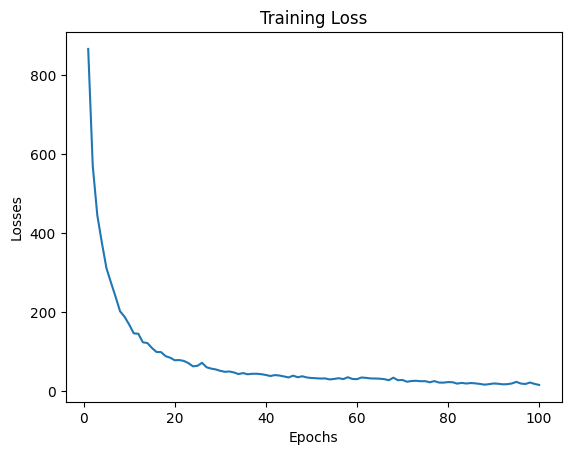

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(history_loss)+1)

# Plot losses
plt.plot(epochs, history_loss)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training Loss")
plt.show()

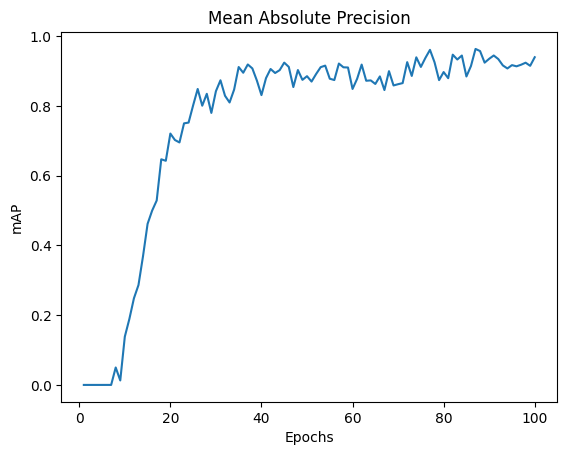

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(history_mAP)+1)

# Plot losses
plt.plot(epochs, history_mAP)
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.title("Mean Absolute Precision")
plt.show()

In [ ]:
# Save the model
#torch.save(model.state_dict(), "/content/drive/MyDrive/DALC/YOLOV1_1.pth")

### Testing and Evaluation

In [ ]:
# Use the trained model to predict label
pred_boxes, target_boxes = get_bboxes(
    test_loader, model, iou_threshold=0.5, threshold=0.4
)

# Calculate the mean average precision after every epoch/training
mean_avg_prec = mean_average_precision(
    pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
)

# Print the mean average precision on test dataset
print(f"Mean Average Precision: {mean_avg_prec:.4f}")

Mean Average Precision: 0.0009


------------------------------------------

In [ ]:
history_loss = [] #For epoch -loss
history_mAP = []

def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    history_loss.append(sum(mean_loss)/len(mean_loss))
    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "/content/drive/MyDrive/DALC/data/100examples.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "/content/drive/MyDrive/DALC/data/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    for epoch in range(EPOCHS):
        # for x, y in train_loader:
        #    x = x.to(DEVICE)
        #    for idx in range(8):
        #        bboxes = cellboxes_to_boxes(model(x))
        #        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        #        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

        #    import sys
        #    sys.exit()

        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")
        history_mAP.append(mean_avg_prec)

        #if mean_avg_prec > 0.9:
        #    checkpoint = {
        #        "state_dict": model.state_dict(),
        #        "optimizer": optimizer.state_dict(),
        #    }
        #    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
        #    import time
        #    time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)


In [ ]:
if __name__ == "__main__":
    main()

Train mAP: 0.0


100%|██████████| 6/6 [00:05<00:00,  1.09it/s, loss=579]

Mean loss was 850.7891235351562


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=459]

Mean loss was 598.6033732096354


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=582]

Mean loss was 480.11094665527344


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=391]

Mean loss was 379.13311767578125


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=401]

Mean loss was 328.2489064534505


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.46it/s, loss=220]

Mean loss was 292.4864451090495


Train mAP: 6.188119186845142e-06


100%|██████████| 6/6 [00:02<00:00,  2.05it/s, loss=167]

Mean loss was 247.86520640055338


Train mAP: 5.62556260774727e-06


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=178]

Mean loss was 219.8007074991862


Train mAP: 2.475677138136234e-05


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=284]

Mean loss was 202.25342305501303


Train mAP: 0.006714110728353262


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=154]

Mean loss was 179.3254852294922


Train mAP: 0.0037522458005696535


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=151]

Mean loss was 160.06395721435547


Train mAP: 0.16532504558563232


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=105]

Mean loss was 144.55432637532553


Train mAP: 0.21233204007148743


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=157]

Mean loss was 130.0301259358724


Train mAP: 0.27006709575653076


100%|██████████| 6/6 [00:02<00:00,  2.24it/s, loss=149]

Mean loss was 118.67151769002278


Train mAP: 0.3780888020992279


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=127]

Mean loss was 112.86599477132161


Train mAP: 0.42120206356048584


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=79.2]

Mean loss was 104.82558695475261


Train mAP: 0.5220455527305603


100%|██████████| 6/6 [00:02<00:00,  2.18it/s, loss=64.1]

Mean loss was 108.04393259684245


Train mAP: 0.6021862030029297


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=89.8]

Mean loss was 97.17556635538737


Train mAP: 0.6140117645263672


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=85.8]

Mean loss was 87.25154368082683


Train mAP: 0.6929380893707275


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=78.3]

Mean loss was 78.79086240132649


Train mAP: 0.7201722264289856


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=85.4]

Mean loss was 82.84340858459473


Train mAP: 0.742293655872345


100%|██████████| 6/6 [00:02<00:00,  2.46it/s, loss=68]

Mean loss was 75.2272720336914


Train mAP: 0.7578787803649902


100%|██████████| 6/6 [00:02<00:00,  2.16it/s, loss=54.1]

Mean loss was 70.42711766560872


Train mAP: 0.8091574907302856


100%|██████████| 6/6 [00:02<00:00,  2.45it/s, loss=78.1]

Mean loss was 68.5720755259196


Train mAP: 0.784663200378418


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=59.9]

Mean loss was 65.54684193929036


Train mAP: 0.8137763142585754


100%|██████████| 6/6 [00:02<00:00,  2.04it/s, loss=74.1]

Mean loss was 64.03242683410645


Train mAP: 0.7671165466308594


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=52.2]

Mean loss was 61.829489390055336


Train mAP: 0.751620888710022


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=53.6]

Mean loss was 63.39062945048014


Train mAP: 0.8148162961006165


100%|██████████| 6/6 [00:03<00:00,  1.98it/s, loss=73.8]

Mean loss was 62.68207041422526


Train mAP: 0.8105648756027222


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=59.1]

Mean loss was 62.70656394958496


Train mAP: 0.8628684878349304


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=89.9]

Mean loss was 66.21448707580566


Train mAP: 0.8153468370437622


100%|██████████| 6/6 [00:02<00:00,  2.06it/s, loss=77.4]

Mean loss was 63.89796447753906


Train mAP: 0.8621717691421509


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=72.4]

Mean loss was 58.1332950592041


Train mAP: 0.7971652150154114


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=56.2]

Mean loss was 50.407843271891274


Train mAP: 0.8732528686523438


100%|██████████| 6/6 [00:02<00:00,  2.08it/s, loss=57.4]

Mean loss was 53.28885714213053


Train mAP: 0.9139240980148315


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=47.9]

Mean loss was 51.55890019734701


Train mAP: 0.772784411907196


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=31.8]

Mean loss was 53.258895556131996


Train mAP: 0.848913311958313


100%|██████████| 6/6 [00:02<00:00,  2.22it/s, loss=45.3]

Mean loss was 49.85880661010742


Train mAP: 0.8626020550727844


100%|██████████| 6/6 [00:02<00:00,  2.45it/s, loss=44]

Mean loss was 51.190041859944664


Train mAP: 0.8895686268806458


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=33]

Mean loss was 45.6041456858317


Train mAP: 0.851385772228241


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=64.8]

Mean loss was 43.76449966430664


Train mAP: 0.9342523813247681


100%|██████████| 6/6 [00:02<00:00,  2.48it/s, loss=34.6]

Mean loss was 43.63857841491699


Train mAP: 0.8332576751708984


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=49]

Mean loss was 44.99853006998698


Train mAP: 0.8679853677749634


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=37.3]

Mean loss was 42.4554967880249


Train mAP: 0.8565400838851929


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=44.2]

Mean loss was 42.59865379333496


Train mAP: 0.8615385293960571


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=60.3]

Mean loss was 41.72073268890381


Train mAP: 0.8825267553329468


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=42.9]

Mean loss was 41.871514002482094


Train mAP: 0.8356630206108093


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=29.8]

Mean loss was 35.94316387176514


Train mAP: 0.8430396318435669


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=45]

Mean loss was 42.76268164316813


Train mAP: 0.9141883850097656


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=50.9]

Mean loss was 51.706397692362465


Train mAP: 0.8488802909851074


100%|██████████| 6/6 [00:02<00:00,  2.19it/s, loss=55.7]

Mean loss was 46.0145689646403


Train mAP: 0.8740118145942688


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=60]

Mean loss was 41.61043739318848


Train mAP: 0.9194575548171997


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=39.6]

Mean loss was 42.17685763041178


Train mAP: 0.8553524017333984


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=35.9]

Mean loss was 35.62744967142741


Train mAP: 0.8752751350402832


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=36.1]

Mean loss was 30.772942225138348


Train mAP: 0.9071853756904602


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=48.6]

Mean loss was 36.05152098337809


Train mAP: 0.8769636154174805


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=47.1]

Mean loss was 35.84986432393392


Train mAP: 0.8872431516647339


100%|██████████| 6/6 [00:02<00:00,  2.45it/s, loss=40.8]

Mean loss was 34.06897004445394


Train mAP: 0.911449134349823


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=26.7]

Mean loss was 36.32457892100016


Train mAP: 0.8674221038818359


100%|██████████| 6/6 [00:02<00:00,  2.19it/s, loss=27]

Mean loss was 42.336506843566895


Train mAP: 0.9113506078720093


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=25.2]

Mean loss was 34.88553015391032


Train mAP: 0.8506091237068176


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=26.4]

Mean loss was 36.43672434488932


Train mAP: 0.9266918897628784


100%|██████████| 6/6 [00:02<00:00,  2.24it/s, loss=49.5]

Mean loss was 42.213058153788246


Train mAP: 0.8672914505004883


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=38.3]

Mean loss was 35.96926720937093


Train mAP: 0.9013107419013977


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=36.6]

Mean loss was 34.105149586995445


Train mAP: 0.9262296557426453


100%|██████████| 6/6 [00:02<00:00,  2.11it/s, loss=30.9]

Mean loss was 33.355045000712074


Train mAP: 0.8674658536911011


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=22.9]

Mean loss was 29.97500737508138


Train mAP: 0.8616504669189453


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=31.3]

Mean loss was 28.757751146952312


Train mAP: 0.8906146287918091


100%|██████████| 6/6 [00:02<00:00,  2.17it/s, loss=49.6]

Mean loss was 29.065062204996746


Train mAP: 0.8968443870544434


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=38]

Mean loss was 30.142528851826984


Train mAP: 0.8928231000900269


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=39]

Mean loss was 27.546805063883465


Train mAP: 0.8636466264724731


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=33]

Mean loss was 28.771445592244465


Train mAP: 0.9046012759208679


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=28.6]

Mean loss was 27.44324556986491


Train mAP: 0.8923047184944153


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=35.5]

Mean loss was 29.000036239624023


Train mAP: 0.8797483444213867


100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=38.7]

Mean loss was 28.06402587890625


Train mAP: 0.8669284582138062


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=42.4]

Mean loss was 27.398425738016766


Train mAP: 0.8641584515571594


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=25.7]

Mean loss was 26.691877047220867


Train mAP: 0.8830318450927734


100%|██████████| 6/6 [00:03<00:00,  1.99it/s, loss=38]

Mean loss was 29.287786801656086


Train mAP: 0.8924188613891602


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=24.2]

Mean loss was 28.422110557556152


Train mAP: 0.9290075302124023


100%|██████████| 6/6 [00:02<00:00,  2.46it/s, loss=27.8]

Mean loss was 27.039196968078613


Train mAP: 0.9161094427108765


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=33.3]

Mean loss was 24.26150639851888


Train mAP: 0.9120944738388062


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=23.4]

Mean loss was 24.71192169189453


Train mAP: 0.8913054466247559


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=41.6]

Mean loss was 24.251464525858562


Train mAP: 0.8736385703086853


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=23]

Mean loss was 25.884273211161297


Train mAP: 0.9047676920890808


100%|██████████| 6/6 [00:02<00:00,  2.20it/s, loss=31.2]

Mean loss was 25.334192593892414


Train mAP: 0.8929128646850586


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=30.5]

Mean loss was 24.962735811869305


Train mAP: 0.8875873684883118


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=23.1]

Mean loss was 26.888158798217773


Train mAP: 0.8987218141555786


100%|██████████| 6/6 [00:02<00:00,  2.19it/s, loss=18.5]

Mean loss was 23.345301628112793


Train mAP: 0.8824169039726257


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=27.3]

Mean loss was 23.79366683959961


Train mAP: 0.8855701088905334


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=25.6]

Mean loss was 21.51018985112508


Train mAP: 0.950248122215271


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=25.7]

Mean loss was 20.757446606953938


Train mAP: 0.8976672291755676


100%|██████████| 6/6 [00:02<00:00,  2.45it/s, loss=17.8]

Mean loss was 21.98333994547526


Train mAP: 0.873660147190094


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=25.8]

Mean loss was 21.651294708251953


Train mAP: 0.8944549560546875


100%|██████████| 6/6 [00:02<00:00,  2.21it/s, loss=20.3]

Mean loss was 19.935078779856365


Train mAP: 0.8943141102790833


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=16.6]

Mean loss was 20.25182851155599


Train mAP: 0.9011133313179016


100%|██████████| 6/6 [00:02<00:00,  2.45it/s, loss=19.4]

Mean loss was 18.71649169921875


Train mAP: 0.8944684267044067


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=17.5]

Mean loss was 20.186291694641113


Train mAP: 0.902970016002655


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=17.4]

Mean loss was 18.66039005915324


Train mAP: 0.9124631881713867


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=17.6]

Mean loss was 17.340169429779053


Train mAP: 0.9197025299072266


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=21.6]

Mean loss was 18.331637223561604


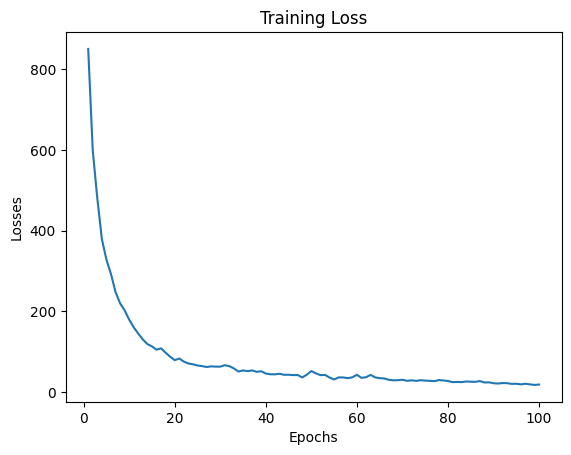

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(history_loss)+1)

# Plot losses
plt.plot(epochs, history_loss)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training Loss")
plt.show()

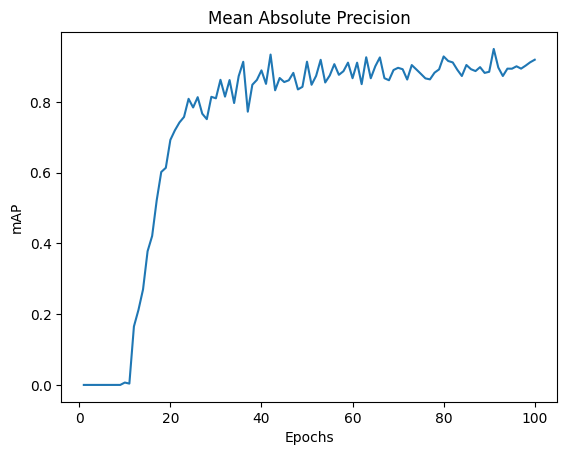

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(history_mAP)+1)

# Plot losses
plt.plot(epochs, history_mAP)
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.title("Mean Absolute Precision")
plt.show()

In [ ]:
# Use the trained model to predict label
pred_boxes, target_boxes = get_bboxes(
    test_loader, model, iou_threshold=0.5, threshold=0.4
)

# Calculate the mean average precision after every epoch/training
mean_avg_prec = mean_average_precision(
    pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
)

# Print the mean average precision on test dataset
print(f"Mean Average Precision: {mean_avg_prec:.4f}")

Mean Average Precision: 0.0015


In [ ]:
def main():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "/content/drive/MyDrive/DALC/data/train.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "/content/drive/MyDrive/DALC/data/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    for epoch in range(EPOCHS):
        # for x, y in train_loader:
        #    x = x.to(DEVICE)
        #    for idx in range(8):
        #        bboxes = cellboxes_to_boxes(model(x))
        #        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        #        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

        #    import sys
        #    sys.exit()

        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")
        history_mAP.append(mean_avg_prec)

        #if mean_avg_prec > 0.9:
        #    checkpoint = {
        #        "state_dict": model.state_dict(),
        #        "optimizer": optimizer.state_dict(),
        #    }
        #    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
        #    import time
        #    time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)


In [ ]:
if __name__ == "__main__":
    main()